# Demodulation of Sagnac

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import obspy


from scipy.fft import fft
from scipy import optimize
from scipy.signal import butter, lfilter, resample, hilbert, ricker


### Setting crucial parameters

In [2]:
## dividing by
div = 10

## set Parameters -------------------------------------

## assumed sagnac frequency 
sgnc = 55

## sampling, time duration and points 
sps = 500
T   = 160
pts = sps * T


## calculate further paremters ------------------------

## time axis
time = np.arange(0, T, 1/sps)

#fg = 0.001

noise = np.random.rand(len(time))



### Defining several methods

In [91]:
class RingLaser:

    def __init__(self, p=None, a=None, wl=None, lat=None):
        self.area = a
        self.perimeter = p
        self.wavelength = wl
        self.latitude = lat

        self.length_of_day = 23*3600+56*60+4.1
        self.earth_rotation_rate = 2 * np.pi / self.length_of_day


    def get_sagnac_frequency(self):

        scale_factor = (4*self.area)/(self.wavelength*self.perimeter)
        projected_omega = self.earth_rotation_rate*np.sin(self.latitude/180.*np.pi)

        return scale_factor * projected_omega

G = RingLaser(p=16., a=16., wl=632.8e-9, lat=49.16)

G_sgnc = G.get_sagnac_frequency()

print(f'Sagnac frequency (G-ring) : {G_sgnc} Hz')

Sagnac frequency (G-ring) : 348.7210635570242 Hz


In [29]:

def __querrySeismoData(seed_id=None, beg=None, end=None, restitute=True):
    '''
    querry seismic traces and station data
    
    Dependencies: 
        from obspy.clients.fdsn import Client, RoutingClient
        
    example:
    	>>> fur, fur_inv = getMeMyData("GR.FUR..BH*", tbeg, tend, restitute=True)
    ''' 
    
    from obspy.clients.fdsn import Client, RoutingClient
      
    ## split seed_id string 
    net, sta, loc, cha = seed_id.split(".")
    
    ## check if input variables are as expected
    for arg in [net, sta, loc, cha, beg, end]:
        if arg is None and not 'loc':
            raise NameError(print(f"\nwell, {arg} has not been defined after all!"))
            exit()
            
    ## state which data is requested        
    if loc != None:
        print(f'\nGet data:  {net}.{sta}.{loc}.{cha} ({float(end-beg)/60}) ...')
    else: 
        print(f'\nGet data:  {net}.{sta}..{cha} (traces of {float(end-beg)/60} min duration) ...')
        
    ## attempting to get data from either EIDA or IRIS.
    try: 
        route = RoutingClient("eida-routing")
        print("\nUsing Eida-Routing...")
        if route:
            inv = route.get_stations(network=net, station=sta, location=loc, channel=cha,
                                     starttime=beg, endtime=end, level="response")
            print(f"\nRequesting from {len(inv.get_contents()['networks'])} network(s) and {len(inv.get_contents()['stations'])} stations")

            st = route.get_waveforms(network=net, station=sta, location=loc, channel=cha, 
                                     starttime=beg, endtime=end)

    except: 
        route = RoutingClient("iris-federator")
        print("\nUsing Iris-Federator...")
        if route:
            inv = route.get_stations(network=net, station=sta, location=loc, channel=cha,
                                     starttime=beg, endtime=end, level="response")
            print(f"\nRequesting from {len(inv.get_contents()['networks'])} network(s) and {len(inv.get_contents()['stations'])} stations")
        
            st = route.get_waveforms(network=net, station=sta, location=loc, channel=cha, 
                                     starttime=beg, endtime=end)
    
    ## remove response of instrument specified in inventory
    if restitute:
               
#        pre_filt = [0.001, 0.005, 45, 50]
        
        out="VEL"  # "DISP" "ACC"
        
        st.remove_response(
            inventory=inv, 
#             pre_filt=pre_fit,
            output=out
        )
        
        print(f"\nremoving response ...")
        print(f"\noutput {out}")
        
    print('\nFinished\n_______________\n')
    
    return st, inv


In [68]:

def __fft(signal_in, dt ,window=None,normalize=None):

	'''
	Calculating a simple 1D FastFourierSpectrum of a time series.

	Example:
	>>> N = 600
	>>> dt = 0.01
	>>> x = np.linspace(0.0, N*dt, N)
	>>> y = np.sin(10.0 * 2.0*np.pi*x) + 0.5*np.sin(15.0 * 2.0*np.pi*x)

	>>> sp, ff = __fft(y,dt,window=True,normalize=False)

	'''

	from scipy.fft import fft, fftfreq, fftshift
	from scipy import signal
	    
	## determine length of the input time series
	n = int(len(signal_in))



	## calculate spectrum (with or without window function applied to time series)
	if window is None or window is False:
		spectrum = fft( signal_in )

	elif window is True:
		window = signal.hann(n); print('Hanning window applied \n')
		#window = signal.kaiser(n, beta=14); print('Kaiser window (beta = 14) applied \n')
		#window = signal.gaussian(n, std=20); print('Gaussian window (std = 20) applied \n')
		spectrum = fft( signal_in * window )

	## calculate frequency array 
	frequencies = fftfreq(n, d=dt)
	

	## correct amplitudes of spectrum and optional normalize
	if normalize == None or normalize == False:
		spectrum_out = 2.0 / n * abs( spectrum )
	
	elif normalize == True:
		spectrum_out = abs( spectrum / abs(spectrum).max()); print('Spectrum normalized \n')

	## return the positive frequencies
	return spectrum_out[1:n//2], frequencies[1:n//2]


In [94]:

def __create_synthetic_event(T, sps, frequency, noise):
    
    '''
    creating a transient event signal by combining ricker wavelets, which is subsequently modulated onto the carrier signal
    
    T         = total time of trace
    sps       = samples per second corresponding to anlog signal
    frequency = dominant frequency of ricker wavelet
    noise     = True/False , to either include or exclude noise for the event signal
    '''
    
    ## shift the transient signal along the trace in time dimension
    offset = 3000
    

    spikes = np.array([1,5,4,8,15,17,70,72,75,79,85])*10 + offset
    ref = np.zeros(int(T*sps))
    rick = ricker(pts, frequency)

    for i in spikes:
        ref[i] = 1
        
    if noise:        
        noise = np.random.rand(T*sps)
        event = np.convolve(rick, ref, 'same') + 0.03 * noise
    else:
        event = np.convolve(rick, ref, 'same')


    event_fft = fft(event)
    #event_fft_db = 20*np.log10(event_fft/max(event_fft))


    ## _______________________________________________________________________________
    ## Plotting 
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

    ff = np.linspace(0,0.5*sps,pts)
    N = len(ff)
    time = np.arange(0,T,1/sps)

    ax1.plot(time,event,color='black')
    ax2.plot(ff[:N // 2],np.abs(event_fft[:N // 2]))

    ax1.set_xlim(min(spikes)/sps-0.1*min(spikes)/sps,max(spikes)/sps+0.1*max(spikes)/sps)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Counts')
    
    ax2.set_xlim(0,200/frequency)
    ax2.set_ylim(0,max(np.abs(event_fft[10:N // 2]))+0.01*max(np.abs(event_fft[:N // 2])))
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Spectral Amplitude')
    
    plt.show();
    
    return time, event


In [4]:

def __analog_to_digital(sgnc, event , T, sps, fsd, factor):

    ''' 
    resample the simulated analog signal to get a digital 
    data stream 
    
    '''

    sig_ana = np.sin(2*np.pi*(sgnc + factor * event ) * time ) 
    #sig_ana = np.sin(2*np.pi*(sgnc ) * time ) 


    ## --------------------------------------------------------------------

    #fsd = sps/2


    sp  = np.arange(0,T*sps,sps/fsd)
    spt = np.arange(0,T,1/fsd)


    sig_dig = []
    for i in sp:
        sig_dig.append(sig_ana[int(i)])

    sig_dig = np.array(sig_dig)

    return sig_dig

    ## _______________________________________________________________________________

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    #ax.scatter(sp,sig,s=0.01)
    #ax.plot(time,sig_ana)

    ax.scatter(spt,sig_dig,s=15,color='black')
    ax.plot(spt,sig_dig,color='grey')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Counts')
    ax.set_xlim(0,0.25)

    plt.show();
    

In [5]:

def __resample_digital_signal(sig_in,fs,fac,taper):

    ''' 
    
    up-samping of the simulated digital signal 
    
    sig_in   = input signal
    fs       = sampling frequency of digital signal
    fac      = sampling factor (2 = double)
    taper    = True/False , to either taper or not taper output
    
    '''
    

    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a


    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y


    def resampling(sig_in,fac,fs,select):

        if select == 1:
            sig_out = resample(sig_in,len(sig_in)*fac)

        elif select == 2:
            sig = list(sig_in); i=0

            while i < len(sig):
                sig.insert(i, 0.0)
                i += 2
            sig_out = np.array(sig)

        time_out = np.arange(0,len(sig_in)/fs,1/(fs*fac))

        return  (sig_out, time_out)



    #sig_dig_fil_res, tt_res = resampling(sig_dig_fil,2,fs,2)
    sig_dig_res, tt_res = resampling(sig_in,2,fs,1)


    sig_dig_res_tap = np.hanning(len(sig_dig_res)) * sig_dig_res
    #sig_dig_res_tap_fil = butter_bandpass_filter(sig_dig_res_tap,0.1,100,fs,4)


    ## _______________________________________________________________________________

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    tt     = tt_res
    signal = sig_dig_res
    
    
    ax.plot(tt,signal,color='grey')

    ax.scatter(tt,signal,s=15,color='black')

    ax.scatter(tt[::2],signal[::2],s=15,color='red')
    #ax.plot(tt[1::2],signal[1::2],color='darkred')


    ax.set_xlim(0,0.25)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Counts')

    plt.show();
    
    ## _______________________________________________________________________________
   
    
    if taper:
        return tt_res, sig_dig_res_tap
    
    elif not taper:
        return tt_res, sig_dig_res
    

In [6]:

def __sinus_fit(input1, input2, step, over):

    ''' Fitting a sin-functionto the resampled data to estimate an instantaneous frequency '''
    
    def func(x, a, b):
        return a * np.sin(2*np.pi* b * x) * np.hanning(len(x))

    dt = (input1[2]-input1[1])

    amps=[]
    freq=[]

    ## create time refernce 
    tt = np.arange(step,len(input1)-step, over) 

    
    for idx in tt:

        idx = int(idx)
        
        ## start values for fit
        a0 = 0.9
        b0 = 54
        b1 = 55
        
        ## condition for fit
        while abs(b0-b1) > 0.1:
            b0 = b1
            params, params_covariance = optimize.curve_fit(func, input1[idx-step:idx+step], np.hanning(len(input2[idx-step:idx+step]))*input2[idx-step:idx+step],p0=[a0, b0])
            b1 = params[1]


        amps.append(params[0])
        freq.append(params[1])
    
    ## convert lists to arrays
    amps = np.array(amps)
    freq = np.array(freq)
    
    
    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    freq = np.insert(freq, 0, np.nan, axis=0)
    tt   = np.insert(tt, 0, 0.0, axis=0)
    
    
    
    ## _______________________________________________________________________________

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    idx1 = 100
    idx2 = idx1+step
    
    xx = np.linspace(input1[idx1],input1[idx2],step*8) 
    
    ax.scatter(input1[idx1:idx2],np.hanning(len(input2[idx1:idx2]))*input2[idx1:idx2],s=10,color='black')
    ax.plot(xx,func(xx,params[0],params[1]),color='red')



    plt.show();
    
    ## _______________________________________________________________________________
   
    
    return  tt*dt , freq


In [7]:

def __instantaneous_frequency_hilbert(sig_in,time_in,fs):
    
    ''' Estimation of the instantaneous frequency (modulated signal) by using integrated python methods '''
    
    sig_hil = hilbert(sig_in)
    
    insta_phase = np.unwrap(np.angle(sig_hil))
    
    insta_freq  = 2* (np.diff(insta_phase) / (2.0 * np.pi)  * fs)

    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    insta_freq = np.insert(insta_freq, 0, np.nan, axis=0)

    
    ## _______________________________________________________________________________

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    ax.plot(time_in,insta_freq,color='grey')

    x1=5
    x2=10

    ax.set_xlim(x1,x2)
    ax.set_ylim(min(insta_freq[int(x1*fs*2):int(x2*fs*2)])-0.5,max(insta_freq[int(x1*fs*2):int(x2*fs*2)])+0.5)

    ax.set_ylabel('$\Delta$ f (Hz)')
    ax.set_xlabel('Time (s)')
    
    plt.show();    
    
    ## _______________________________________________________________________________

    return time_in, insta_freq


In [8]:

def __hibert_filter(sig_in,time_in,fs):
    
    '''
    estimating the instantaneous frequency by using the formula of Jo
    
    sig_in    = input signal
    time_in   = input timeline
    fs        = sampling frequency of digital signal
    '''
    
    hil0 = hilbert(sig_in)
    hil = np.imag(hil0)
    
    delta_f_full = (sig_in[1:]*np.diff(hil) - np.diff(sig_in) * hil[1:]) / (2*np.pi*(sig_in[1:]**2 + hil[1:]**2))

    delta_f = np.real(delta_f_full)
    
    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    delta_f = np.insert(delta_f, 0, np.nan, axis=0)

    ## _______________________________________________________________________________

    fig, ax = plt.subplots(1,1,figsize=(15,5))

#    ax.plot(time_in[1:],delta_f,color='grey')
    ax.plot(time_in,delta_f,color='grey')

    x1=5
    x2=10

    ax.set_xlim(x1,x2)
    ax.set_ylim(min(delta_f[int(x1*fs):int(x2*fs)])-0.5,max(delta_f[int(x1*fs):int(x2*fs)])+0.5)

    ax.set_ylabel('$\Delta$ f (Hz)')
    ax.set_xlabel('Time (s)')
    
    plt.show();    
    
    ## _______________________________________________________________________________

#    return time_in[1:], delta_f
    return time_in, delta_f


In [9]:

def __makeplot_diff(time_in, sig_in):

    
    fig, ax = plt.subplots(1,1,figsize=(15,5))

    ax.plot(time_in,sig_in, color='black')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')

    plt.show()


In [10]:

def __makeplot_comparison(time_in1, sig_in, time_in2, event_in, option, sps, sgnc):

    x1 = 5
    x2 = 10

    if option == 'option1' or option == 'option2':
        signal = sig_in - sgnc
    elif option == 'option3':
        signal = sig_in

    fig, ax = plt.subplots(1,1,figsize=(15,5))

    ax.plot(time_in2,event_in,color='black')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')


    ax.set_xlim(x1,x2)
    ax.set_ylim(-max(abs(event_in[x1*sps:x2*sps])),max(abs(event_in[x1*sps:x2*sps])))

    ax2 = ax.twinx()
    ax2.plot(time_in1, signal,color='red')

    ax2.set_ylabel('$\Delta$ f (Hz)')
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')

    if option == 'option1':
        ax2.set_ylim(-max(abs(signal[int(x1*sps/2):int(x2*sps/2)])),max(abs(signal[int(x1*sps/2):int(x2*sps/2)])))
    elif option == 'option2':
        ax2.set_ylim(-max(abs(signal[int(x1*sps):int(x2*sps)])),max(abs(signal[int(x1*sps):int(x2*sps)])))
    elif option == 'option3':
        ax2.set_ylim(-max(abs(signal[int(x1*sps):int(x2*sps)])),max(abs(signal[int(x1*sps):int(x2*sps)])))


    plt.show();


In [86]:
def __makeplot_trace_and_spectrum(trace, timeline):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    trace_fft, ff = __fft(signal_in=trace, dt=trace.stats.delta , window=None, normalize=None)

    ax1.plot(timeline, trace)

    ax2.plot(ff[:N // 2],np.abs(trace_fft[:N // 2]))

    plt.show();


### Querry seismic data 

In [32]:
tbeg = obspy.UTCDateTime(2020, 10, 30, 11, 50)
tend = obspy.UTCDateTime(2020, 10, 30, 12, 20)

RLAS, RLAS_inv = __querrySeismoData("BW.RLAS..BJZ", tbeg, tend, 
                                    restitute=True)

RLAS.plot();


Get data:  BW.RLAS..BJZ (30.0) ...

Using Eida-Routing...

Requesting from 1 network(s) and 1 stations

removing response ...

output VEL

Finished
_______________



/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/core/inventory/response.py:1193: UserWarning: The unit 'RAD/S' is not known to ObsPy. It will be assumed to be displacement for the calculations. This mostly does the right thing but please proceed with caution.
  warnings.warn(msg)


### Process seismic data

Maximum amplitude RLAS:  3.41066942851e-08 rad/s
Maximum amplitude dat:  -1.71214928916e-08 rad/s


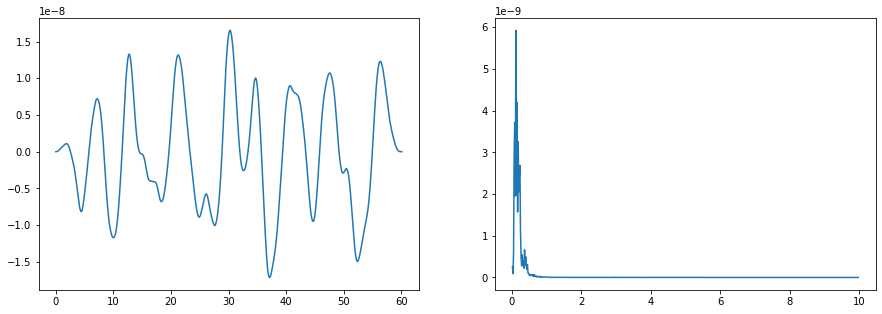

In [88]:
if 'dat' in globals():
    del dat
    
dat = RLAS[0].copy()

## filter corners
dat.filter("lowpass", freq=1.0, corners=2)

## Sampling rate of original seismogram and sampling interval
dt, fs  = dat.stats.delta, 1/dat.stats.delta

## Choose window (otherwise core runs too long)
shift = 12 # minutes
dat.trim(tbeg+shift*60, tbeg+(shift+1)*60)


## Taper at both ends (one could also use obspy taper!)
dat.taper(0.1, type='hann', max_length=None, side='both')

## Initialize time for original data
timeline = np.linspace(0, np.size(dat) * dt, np.size(dat))

## Print metadata and min max values 
print('Maximum amplitude RLAS: ', RLAS[0].max(), 'rad/s')
print('Maximum amplitude dat: ', dat.max(), 'rad/s')

## for further code to work
torig = timeline
data = dat

## _______________________________________________

__makeplot_trace_and_spectrum(dat, timeline)

### Choosing configuration

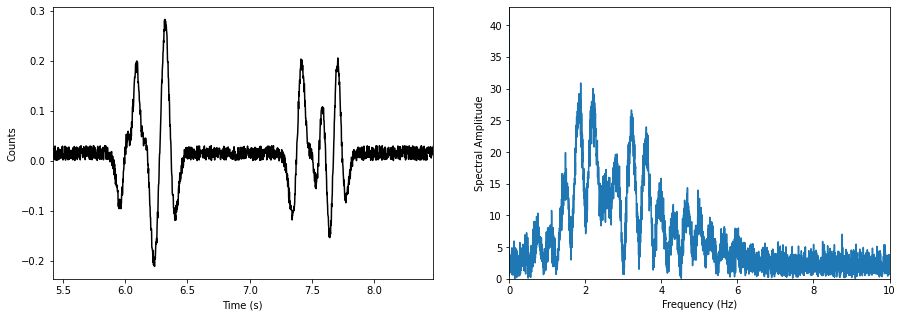

TypeError: unsupported operand type(s) for *: 'float' and 'Trace'

In [101]:
## set sampling frequency for digital signal 
fs_digi = sps/2


"""creating an event with center frequency fc"""
fc = 20 # Hz
tt_event, event = __create_synthetic_event(T, sps, fc, True)

"""sampling the synthetic analog signal to a digital time series"""
#sig_dig = __analog_to_digital(sgnc, event, T, sps, fs_digi, 0.1)
sig_dig = __analog_to_digital(G_sgnc, dat, T, sps, fs_digi, 0.1)

"""interpolate the digital time series"""
#tt_res, sig_dig_res = __resample_digital_signal(sig_dig, fs_digi, 1, False)


# _____________________________________________________________________________________________________________
#tt_demod, sig_demod = __sinus_fit(tt_res, sig_dig_res, 10, 2) ; option = 'option1'

# _____________________________________________________________________________________________________________
#tt_demod, sig_demod = __instantaneous_frequency_hilbert(sig_dig_res, tt_res, fs_digi) ; option = 'option2'

# _____________________________________________________________________________________________________________
#tt_demod, sig_demod = __hibert_filter(sig_dig_res,tt_res,fs_digi) ; option = 'option3'




## _______________________________________________________________________________


__makeplot_comparison(tt_demod, sig_demod, tt_event, event, option, sps, sgnc)


__makeplot_diff(tt_demod, sig_demod-event)
